In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
start = '2012-01-01' #last 12 years data
end = '2024-12-21'
stock = 'GOOG' #stock data

data = yf.download(stock, start, end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
data

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2012-01-03,16.495001,16.562924,16.171749,16.185880,147611217
2012-01-04,16.566147,16.614982,16.376262,16.485582,114989399
2012-01-05,16.336349,16.459304,16.267435,16.413692,131808205
2012-01-06,16.113495,16.360891,16.107792,16.339819,108119746
2012-01-09,15.430305,16.038633,15.399813,16.026237,233776981
...,...,...,...,...,...
2024-12-16,197.934509,200.411683,193.889115,194.143830,32248600
2024-12-17,196.895676,202.649131,196.466172,198.304075,24129500


In [ ]:
data.reset_index(inplace=True)  #rest date to index

In [5]:
data

Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2012-01-03,16.495001,16.562924,16.171749,16.185880,147611217
1,2012-01-04,16.566147,16.614982,16.376262,16.485582,114989399
2,2012-01-05,16.336349,16.459304,16.267435,16.413692,131808205
3,2012-01-06,16.113495,16.360891,16.107792,16.339819,108119746
4,2012-01-09,15.430305,16.038633,15.399813,16.026237,233776981
...,...,...,...,...,...,...
3259,2024-12-16,197.934509,200.411683,193.889115,194.143830,32248600
3260,2024-12-17,196.895676,202.649131,196.466172,198.304075,24129500
3261,2024-12-18,189.933609,198.463899,189.064604,196.606015,27638400


In [6]:
ma_100_days = data.Close.rolling(100).mean() #moving average of 100 days

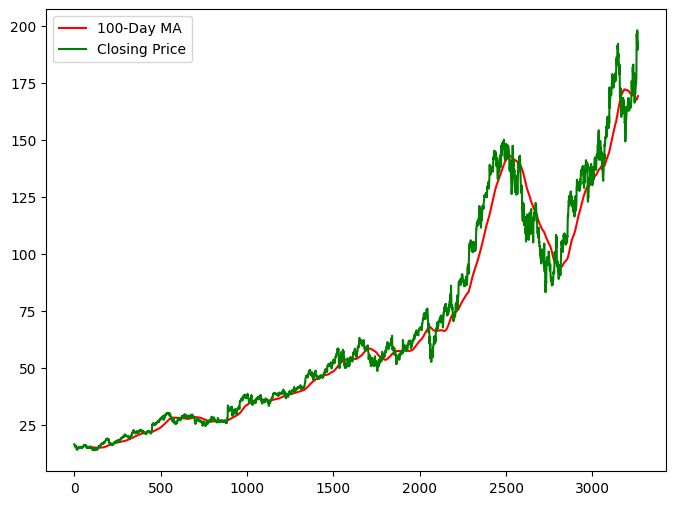

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='100-Day MA') #(smoother trend).
plt.plot(data.Close, 'g', label='Closing Price')
plt.legend()
plt.show()

In [10]:
ma_200_days = data.Close.rolling(200).mean()

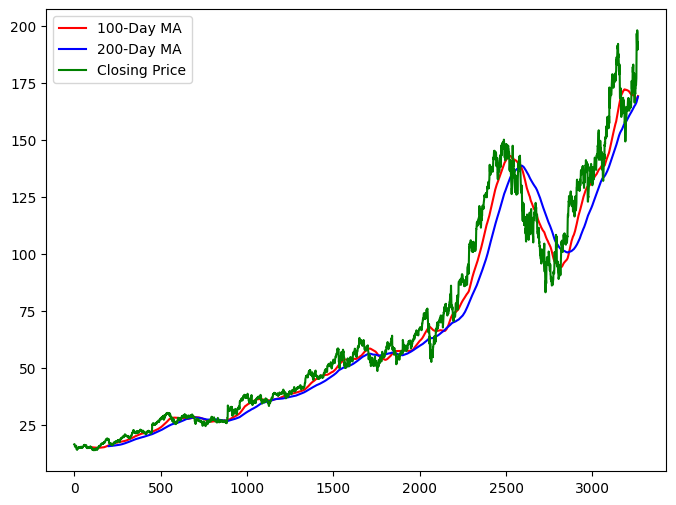

In [11]:
plt.figure(figsize=(8,6))
plt.plot(ma_100_days, 'r', label='100-Day MA')
plt.plot(ma_200_days,'b', label='200-Day MA')
plt.plot(data.Close,'g', label='Closing Price')
plt.legend()
plt.show()

In [ ]:
data.dropna(inplace=True) #dropping null values

In [ ]:
#train-test split on closing price
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [14]:
data_train.shape[0]

2611

In [15]:
data_test.shape[0]

653

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [17]:
data_train_scale = scaler.fit_transform(data_train)

In [ ]:
#array slicing
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])

In [20]:
x, y = np.array(x), np.array(y)

In [21]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [ ]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,input_shape = ((x.shape[1],1))))
                                         #output of one layer will be the input of next
               
model.add(Dropout(0.2)) #20% dropout to prevent overfitting

model.add(LSTM(units = 60, activation='relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units =1)) #predicting only the closing price

c:\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [24]:
model.fit(x,y, epochs = 50, batch_size =32, verbose =1)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - loss: 0.0546
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 165ms/step - loss: 0.0061
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - loss: 0.0049
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 0.0039
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 0.0036
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - loss: 0.0036
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - loss: 0.0037
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - loss: 0.0035
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - loss: 0.0031
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - loss: 0.0028
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - loss: 0.0034
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 0.0029
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - loss: 0.0023
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 201ms/step - loss: 0.0031
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 